In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [16]:
data = pd.read_csv("/content/drive/My Drive/Dataset/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [17]:
data.shape

(284807, 31)

In [18]:
data.isnull().sum().sum()

0

# Visualization

In [19]:
len(data[data['Class']==0])

284315

In [20]:
len(data[data['Class']==1])

492

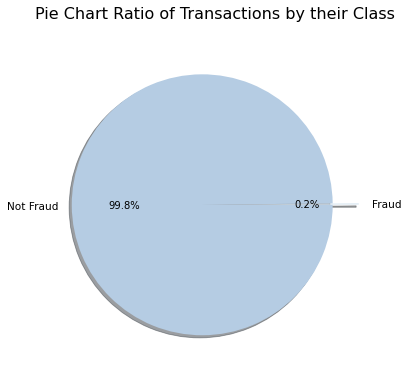

In [21]:
import seaborn as sns
fraud =len(data[data['Class']==1])
notfraud = len(data[data['Class']==0])

# Data to plot
labels = 'Fraud','Not Fraud'
sizes = [fraud,notfraud]

# Plot
plt.figure(figsize=(7,6))
plt.pie(sizes, explode=(0.1, 0.1), labels=labels, colors=sns.color_palette("BuPu"),
autopct='%1.1f%%', shadow=True, startangle=0)
plt.title('Pie Chart Ratio of Transactions by their Class\n', fontsize=16)
sns.set_context("paper", font_scale=1.2)

**The dataset is highly imbalanced which could lead us to create an algorithm resulting in predicting only 1 type of class. Thus, we have to try different strategies as a solution to imbalance class problem.** Here are the few techniques that can be used for such a problem:

1. Try Changing Performance Metric
2. Try Resampling Dataset
3. Try Generating Synthetic Samples
4. Try Different Algorithms

## Standarize our data

In [0]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

data['scaled_amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
#data['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

data.drop(['Time','Amount'], axis=1, inplace=True)

In [23]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579


In [24]:
data.shape

(284807, 30)

# Model Building and testing

In [0]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,recall_score,precision_recall_curve,average_precision_score

One of the major issues that novice users fall into when dealing with unbalanced datasets relates to the metrics used to evaluate their model. Using simpler metrics like accuracy_score can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously illusory.

In [26]:
y = data['Class']
X = data.drop(['Class'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy is {:.2f}%".format(accuracy * 100.0))

Test Accuracy is 99.94%


**Again trying to run a predictive model on first 3 features "V1", "V2", "V3" we should notice a change in model's performance**

In [27]:
model = XGBClassifier()
model.fit(X_train[['V1','V2','V3']], y_train)

y_pred = model.predict(X_test[['V1','V2','V3']])
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy is {:.2f}%".format(accuracy * 100.0))

Test Accuracy is 99.85%


The model accuracy hasn't differed by much suggesting that the achieved acccuracy is just an illusion which is caused due to imbalanced class dataset. Below we can actually see how the proportion of observations are actually predicted for each class using Confusion Matrix.

## Confusion matrix

An interesting way to evaluate the results is by means of a confusion matrix, which shows the correct and incorrect predictions for each class, and the higher the diagonal values of the confusion matrix, indicating many correct predictions.

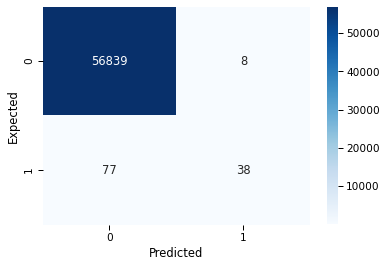

In [28]:
# assign cnf_matrix with result of confusion_matrix array
cnf_matrix = confusion_matrix(y_test,y_pred)
#create a heat map
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'Blues', fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

# Resampling Technique

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

**Note: Always split the dataset into test and train sets BEFORE trying any resampling techniques!**

In [0]:
from sklearn.utils import resample
# Separate input features and target
Y = data.Class
X = data.drop(['Class'], axis=1)

# setting up testing and training sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=2727)

# concatenate our training data back together
X = pd.concat([X_train, Y_train], axis=1)

**Oversampling before splitting the data can allow the exact same observations to be present in both the test and train sets. This can allow our model to simply memorize specific data points and cause overfitting and poor generalization to the test data.**

## 1: Random over-sampling minority class

Oversampling can be defined as adding more copies of the minority class. Oversampling can be a good choice when you don’t have a ton of data to work with.

In [30]:
# separate minority and majority classes
not_fraud = X[X.Class==0]
fraud = X[X.Class==1]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=2727) # reproducible results

# combine majority and oversampled minority
oversampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
oversampled.Class.value_counts()

1    199032
0    199032
Name: Class, dtype: int64

After resampling we have an equal ratio of data points for each class! Let’s try our above XGBoost Classifier again with the balanced training data.

In [0]:
# trying xgboost again with the balanced dataset
y_train = oversampled.Class
X_train = oversampled.drop('Class', axis=1)

upsampled = XGBClassifier()
upsampled.fit(X_train, y_train)

# Predict on test
upsampled_pred = upsampled.predict(X_test)

# predict probabilities
probs = upsampled.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]

In [32]:
# Checking accuracy
accuracy = accuracy_score(Y_test, upsampled_pred)
print("Test Accuracy is {:.2f}%".format(accuracy * 100.0))

Test Accuracy is 99.61%


In [33]:
# f1 score
f1_over = f1_score(Y_test, upsampled_pred)
print("F1 Score is {:.2f}%".format(f1_over))

F1 Score is 0.45%


ERROR! Session/line number was not unique in database. History logging moved to new session 59


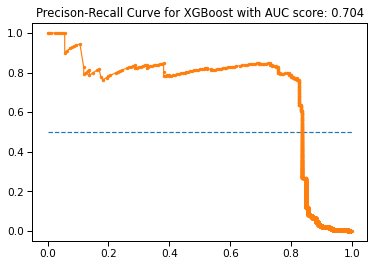

In [34]:
from sklearn.metrics import auc
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, probs)
# calculate precision-recall AUC
auc_over = auc(recall, precision)
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.')
plt.title("Precison-Recall Curve for XGBoost with AUC score: {:.3f}".format(auc_over))
# show the plot
plt.show()

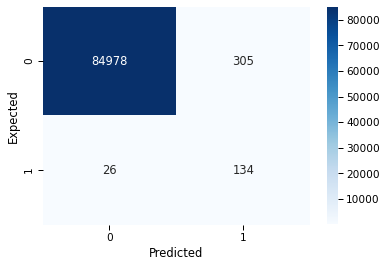

In [35]:
# assign cnf_matrix with result of confusion_matrix array
cnf_matrix = confusion_matrix(Y_test,upsampled_pred)
#create a heat map
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'Blues', fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

## 2: Random under-sampling majority class

Undersampling can be defined as removing some observations of the majority class. Undersampling can be a good choice when you have a ton of data -think millions of rows. But a drawback is that we are removing information that may be valuable. This could lead to underfitting and poor generalization to the test set.

In [36]:
# still using our separated classes fraud and not_fraud from above

# downsample majority
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.Class.value_counts()

1    332
0    332
Name: Class, dtype: int64

In [0]:
# trying xgboost again with the balanced dataset
y_train = downsampled.Class
X_train = downsampled.drop('Class', axis=1)

undersampled = XGBClassifier()
undersampled.fit(X_train, y_train)

# Predict on test
undersampled_pred = undersampled.predict(X_test)
# predict probabilities
probs = undersampled.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]

In [38]:
# Checking accuracy
accuracy = accuracy_score(Y_test, undersampled_pred)
print("Test Accuracy is {:.2f}%".format(accuracy * 100.0))

Test Accuracy is 96.57%


In [39]:
# f1 score
f1_under = f1_score(Y_test, undersampled_pred)
print("F1 Score is {:.2f}%".format(f1_under))

F1 Score is 0.09%


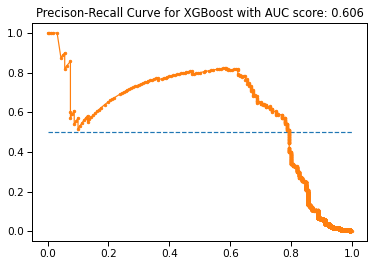

In [40]:
from sklearn.metrics import auc
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, probs)
# calculate precision-recall AUC
auc_under = auc(recall, precision)
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.')
plt.title("Precison-Recall Curve for XGBoost with AUC score: {:.3f}".format(auc_under))
# show the plot
plt.show()

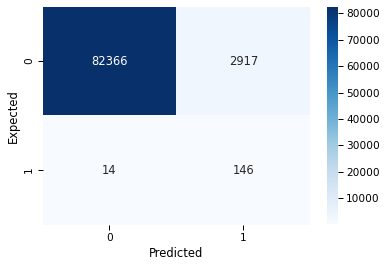

In [41]:
# assign cnf_matrix with result of confusion_matrix array
cnf_matrix = confusion_matrix(Y_test,undersampled_pred)
#create a heat map
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'Blues', fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

# SMOTE

Synthetic Minority Over-sampling Technique has been designed to generate new samples that are coherent with the minor class distribution. The main idea is to consider the relationships that exist between samples and create new synthetic points along the segments connecting a group of neighbors. Below is the python code for implementing SMOTE.

In [43]:
from imblearn.over_sampling import SMOTE

# Separate input features and target
Y = data.Class
X = data.drop(['Class'], axis=1)

# setting up testing and training sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=2727)

sm = SMOTE(random_state=2727, ratio=1.0)
X_train, Y_train = sm.fit_sample(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


**Restructure X_train & Y_train to execute XGBoost algorithm**

In [0]:
X_train = pd.DataFrame(data=X_train)
X_train.columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'scaled_amount']
Y_train = pd.Series(Y_train)

In [0]:
smote = XGBClassifier()
smote.fit(X_train, Y_train)

# Predict on test
smote_pred = smote.predict(X_test)
# predict probabilities
probs = smote.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]

In [49]:
# Checking accuracy
accuracy = accuracy_score(Y_test, smote_pred)
print("Test Accuracy is {:.2f}%".format(accuracy * 100.0))

Test Accuracy is 99.19%


In [50]:
# f1 score
f1_smote = f1_score(Y_test, smote_pred)
print("F1 Score is {:.2f}%".format(f1_smote))

F1 Score is 0.28%


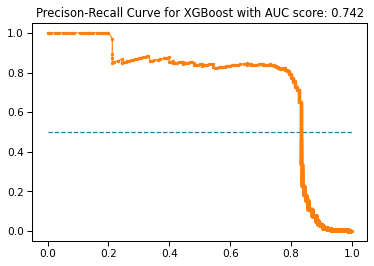

In [51]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, probs)
# calculate precision-recall AUC
auc_smote = auc(recall, precision)
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.')
plt.title("Precison-Recall Curve for XGBoost with AUC score: {:.3f}".format(auc_smote))
# show the plot
plt.show()

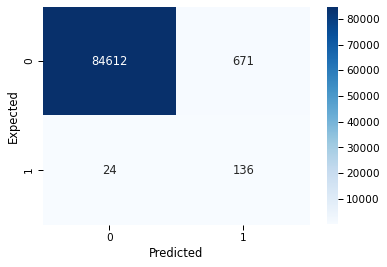

In [52]:
# assign cnf_matrix with result of confusion_matrix array
cnf_matrix = confusion_matrix(Y_test,smote_pred)
#create a heat map
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'Blues', fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

# Conclusion

So far we tried using various performance metrics like Confusion matrix, F1-Score, Precision-Recall curve for different techniques like over-sampling of minority class, under-sampling of majority class and SMOTE (Synthetic Minority Over-Sampling Technique). Based on our evaluation metrics we found that undersampling of majority class resulted in poor poerformance when compared to Over-Sampling techniques and SMOTE. It's still hard to pick a winner here. The algorithm we used in all the scenario was XGBoost.




Text(0.5, 1.0, 'Performance based on AUC Score')

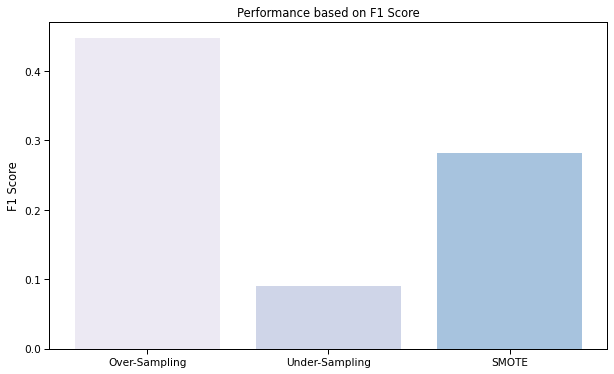

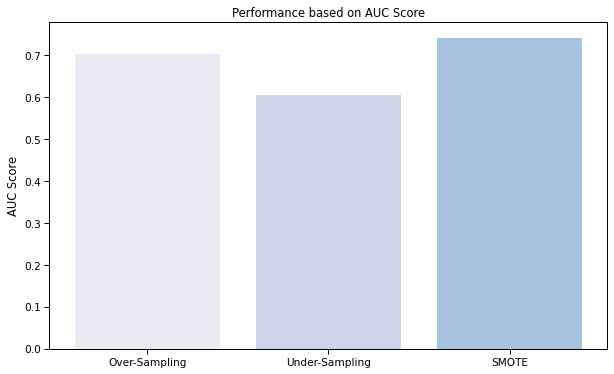

In [53]:
# F1 Score list for all models
f1 = [f1_over, f1_under, f1_smote]
# AUC Score list for all models
auc = [auc_over, auc_under, auc_smote]
# Name List of ML Models used
models = ['Over-Sampling', 'Under-Sampling', 'SMOTE']
y_pos = np.arange(len(models)) #Position = 0,1,2

# Plot F1 Score
plt.figure(figsize=(10, 6))  
plt.bar(y_pos, f1, align='center', alpha=0.8, color=sns.color_palette("PuBu"))
plt.xticks(y_pos, models)
plt.ylabel('F1 Score')
plt.title('Performance based on F1 Score')

# Plot AUC Score
plt.figure(figsize=(10, 6))  
plt.bar(y_pos, auc, align='center', alpha=0.8, color=sns.color_palette("PuBu"))
plt.xticks(y_pos, models)
plt.ylabel('AUC Score')
plt.title('Performance based on AUC Score')